In [1]:
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier, XGBRFClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import *
from xgboost import XGBClassifier
import lightgbm as lgb
import seaborn as sns
from sklearn.ensemble import *
from catboost import CatBoostClassifier
import numpy as np
import itertools

In [2]:
os.chdir('..')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df=pd.read_csv('artifacts/data_transformation/train.csv')

In [5]:
df = df.loc[:, ~df.columns.str.startswith('NATURE')]

In [ ]:
int_cols=df.loc[:,df.columns.str.startswith('ST_GENERAL')].columns.to_list()+(df.loc[:,df.columns.str.startswith('PRODUCT')].columns.to_list())+ (df.loc[:,df.columns.str.startswith('GENDER')].columns.to_list())
int_cols+=['AGE','A_SCORE_VALUE']

for col in int_cols:
    df[col]=df[col].astype(int)
    

In [6]:
df.head()

,ACC_NO,MIN_DUE_AMT_1,MIN_DUE_AMT_2,MIN_DUE_AMT_3,MIN_DUE_AMT_4,MIN_DUE_AMT_5,MIN_DUE_AMT_6,OVER_LIMIT_FEE_1,OVER_LIMIT_FEE_2,OVER_LIMIT_FEE_3,OVER_LIMIT_FEE_4,OVER_LIMIT_FEE_5,OVER_LIMIT_FEE_6,TOT_SPEND_AMT_1,TOT_SPEND_AMT_2,TOT_SPEND_AMT_3,TOT_SPEND_AMT_4,TOT_SPEND_AMT_5,TOT_SPEND_AMT_6,PAYMENT_AMT_1,PAYMENT_AMT_2,PAYMENT_AMT_3,PAYMENT_AMT_4,PAYMENT_AMT_5,PAYMENT_AMT_6,TOTAL_OS_1,TOTAL_OS_2,TOTAL_OS_3,TOTAL_OS_4,TOTAL_OS_5,TOTAL_OS_6,LATE_PAY_FEE_1,LATE_PAY_FEE_2,LATE_PAY_FEE_3,LATE_PAY_FEE_4,LATE_PAY_FEE_5,LATE_PAY_FEE_6,A_SCORE_VALUE,FINAL_LIMIT,3_MONTH_NPL_STATUS,AGE,MONTH_END_BAL_LCY,REV_SETT_1_REVOLVER,REV_SETT_1_SETTLER,REV_SETT_2_REVOLVER,REV_SETT_2_SETTLER,REV_SETT_3_REVOLVER,REV_SETT_3_SETTLER,REV_SETT_4_REVOLVER,REV_SETT_4_SETTLER,REV_SETT_5_REVOLVER,REV_SETT_5_SETTLER,REV_SETT_6_REVOLVER,REV_SETT_6_SETTLER,RESTRUCTURED_PLAN_N,RESTRUCTURED_PLAN_Y,ST_GENERAL_ACC_BLCK,ST_GENERAL_ACC_CLST,ST_GENERAL_ACC_DACL,ST_GENERAL_ACC_DCBK,ST_GENERAL_ACC_DLNQ,ST_GENERAL_ACC_DRSP,ST_GENERAL_ACC_NORM,ST_GENERAL_ACC_PCLS,ST_GENERAL_ACC_RCDF,ST_GENERAL_ACC_RCLS,ST_GENERAL_ACC_RCPM,ST_GENERAL_ACC_RCSM,ST_GENERAL_ACC_RCSS,ST_GENERAL_ACC_RSET,ST_GENERAL_ACC_SACC,ST_GENERAL_ACC_SETT,ST_GENERAL_ACC_TERM,ST_GENERAL_ACC_WROF,GENDER_F,GENDER_M,PRODUCT_P13635,PRODUCT_P2f44d,PRODUCT_P3c2a4,PRODUCT_P3dbc4,PRODUCT_P59e14,PRODUCT_P78a55,PRODUCT_P7fc9a,PRODUCT_P8f4b3,PRODUCT_Pacee4,PRODUCT_Pd9c22,PRODUCT_Pdbb26,PRODUCT_Pdc921,PRODUCT_Pf4d80
0,93944.0,542.70,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,12896.00,78185.72,16409.23,9008.00,0.00,0.00,3000.0,0.0,42000.0,3000.0,1000.0,2000.0,137387.06,125209.110,46277.59,65720.36,59712.36,60712.36,1750.0,0.0,0.0,0.0,0.0,0.0,194.0,317000.0,0.0,56.0,397.13,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7238.0,7798.39,4076.19,2045.47,1551.43,7527.77,887.62,0.0,0.0,0.0,0.0,0.0,0.0,79873.03,67408.22,165612.27,87593.55,42954.06,179232.44,195000.0,51500.0,52000.0,39000.0,188200.0,22500.0,140000.80,255127.770,232021.77,117428.98,68785.43,213981.38,0.0,0.0,1750.0,0.0,0.0,0.0,217.0,1000000.0,0.0,35.0,0.00,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11226.0,0.00,0.00,0.00,0.00,0.00,250.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,-76.31,-76.310,-76.31,-76.31,-76.31,-76.31,0.0,0.0,0.0,0.0,0.0,0.0,231.0,1037000.0,0.0,55.0,0.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,94712.0,818.80,650.04,579.68,830.91,577.58,636.81,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,1739.70,0.00,0.00,6314.00,13000.0,20500.0,16300.0,14500.0,20800.0,14500.0,97219.38,110219.375,130469.38,139029.67,153529.69,174329.67,0.0,0.0,0.0,0.0,0.0,0.0,233.0,500000.0,0.0,37.0,0.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,119466.0,570.24,618.13,602.91,250.00,250.00,250.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,42779.00,8278.68,17041.09,2238.00,0.00,15000.0,15500.0,16200.0,5500.0,3500.0,3500.0,97667.70,112667.700,85388.70,93310.02,81768.93,83030.93,0.0,0.0,0.0,0.0,0.0,1750.0,201.0,376000.0,0.0,56.0,0.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_1=df.copy()

In [8]:
df_1['LATE_PAY_FEE']=df_1['LATE_PAY_FEE_1']+df_1['LATE_PAY_FEE_2']+df_1['LATE_PAY_FEE_3']+df_1['LATE_PAY_FEE_4']+df_1['LATE_PAY_FEE_5']+df_1['LATE_PAY_FEE_6']


df_1['OVER_LIMIT_FEE']=df_1['OVER_LIMIT_FEE_1']+df_1['OVER_LIMIT_FEE_2']+df_1['OVER_LIMIT_FEE_3']+df_1['OVER_LIMIT_FEE_4']+df_1['OVER_LIMIT_FEE_5']+df_1['OVER_LIMIT_FEE_6']

In [9]:
df_1=df_1.drop(columns=['LATE_PAY_FEE_1','LATE_PAY_FEE_2','LATE_PAY_FEE_3','LATE_PAY_FEE_4','LATE_PAY_FEE_5','LATE_PAY_FEE_6'])

df_1=df_1.drop(columns=['OVER_LIMIT_FEE_1','OVER_LIMIT_FEE_2','OVER_LIMIT_FEE_3','OVER_LIMIT_FEE_4','OVER_LIMIT_FEE_5','OVER_LIMIT_FEE_6'])

In [10]:
df_2=df_1.copy()

df_2=df_2.drop(columns=['A_SCORE_VALUE'])

In [11]:
df_3=df_2.copy()

df_3['TOTAL_OS']=(df_3['TOTAL_OS_1']+df_3['TOTAL_OS_2']+df_3['TOTAL_OS_3']+df_3['TOTAL_OS_4']+df_3['TOTAL_OS_5']+df_3['TOTAL_OS_6'])/6

df_3=df_3.drop(columns=['TOTAL_OS_1','TOTAL_OS_2','TOTAL_OS_3','TOTAL_OS_4','TOTAL_OS_5','TOTAL_OS_6','PRODUCT_Pdbb26'])

In [12]:
df1=df_3.drop(columns=['ACC_NO'])

In [13]:
x=df1.drop(columns=['3_MONTH_NPL_STATUS'])
y=df1.loc[:,['3_MONTH_NPL_STATUS']]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,stratify=y,shuffle=True)

In [40]:
params2 = {
    
    'scale_pos_weight': [270,300,250,200,150],
    'max_depth': [5,7,9,11,13,21],
    'min_child_weight': [17,7,9,11,13,21],
    'subsample': [0.65],
    'colsample_bytree': [0.9],
    'objective':['binary:logistic'],
    'eta':[0.05,0.1,0.01,0.5],
    'gamma':[0.1,0.05,0.01,0.5],
    'enable_categorical': [True],
    'n_estimators': [1000],
    'seed': [42],
    'alpha':[0.05,0.1,0.01,0.5],
    'eval_metric':['auc']
}

metrics_dict = {
    'AUC':[''],
    'F1':[''],
    'Precision 1':[''],
    'Recall 0':[''],
    'Recall 1':[''],
    'Accuracy':['']
}

In [41]:
keys = params2.keys()
values = params2.values()
metrics_keys=metrics_dict.keys()

# Create the cartesian product of all parameter lists
combinations = itertools.product(*values)

# Loop through each combination, create a dictionary, and print it
for combination in combinations:
    param_dict = dict(zip(keys, combination))
    
    clf_xgb = XGBClassifier(**param_dict,)
    clf_xgb.fit(X_train,y_train)
    xgb_pred = clf_xgb.predict(X_test)
    
    metrics_values=('{:.2f}%'.format(roc_auc_score(y_test, xgb_pred) * 100),
    '{:.2f}%'.format(f1_score(y_test, xgb_pred) * 100),
    '{:.2f}%'.format(precision_score(y_test, xgb_pred) * 100),
    '{:.2f}%'.format(recall_score(y_test, xgb_pred,pos_label=0) * 100),
    '{:.2f}%'.format(recall_score(y_test, xgb_pred) * 100),
    '{:.2f}%'.format(accuracy_score(y_test, xgb_pred) * 100))
    
    metrics_final_dict = dict(zip(metrics_keys, metrics_values))
    
    final_dict = {**param_dict,**metrics_final_dict}
    
    del final_dict['enable_categorical']
    del final_dict['objective']
    del final_dict['seed']
    
    results=pd.DataFrame([final_dict])
    
    results.to_csv('XGB_results.csv',index=True, mode='a', header=False)
    #results.to_csv('XGB_results.csv',index=True, header=True)
    
    #break

KeyboardInterrupt: 

In [29]:
final_dict

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'scale_pos_weight': 200,
 'learning_rate': 0.05,
 'min_child_weight': 17,
 'num_leaves': 10,
 'max_depth': 3,
 'subsample': 0.5,
 'colsample_bytree': 0.5,
 'verbosity': -1,
 'n_estimators': 1000,
 'seed': 42,
 'AUC': '72.16%',
 'F1': '9.70%',
 'Precision 1': '5.39%',
 'Recall 0': '96.23%',
 'Recall 1': '48.09%',
 'Accuracy': '96.01%'}

In [77]:
params_check = {
    'scale_pos_weight': 270,
    'max_depth': 5,
    'min_child_weight': 17,
    'subsample': 0.65,
    'colsample_bytree': 0.9,
    'objective':'binary:logistic',
    'eta':0.05,
    'gamma':0.01,
    'enable_categorical': True,
    'n_estimators': 1000,
    'seed': 42,
    'alpha':0.01,
    'eval_metric':'auc'
}

In [78]:
clf_xgb = XGBClassifier(**params_check)

clf_xgb.fit(X_train,y_train)


XGBClassifier(alpha=0.01, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.05, eval_metric='auc',
              feature_types=None, gamma=0.01, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=17, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, ...)

In [79]:
xgb_pred = clf_xgb.predict(X_test)
xgb_pred_prob = clf_xgb.predict_proba(X_test)

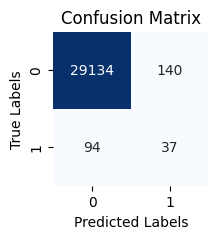

In [ ]:

conf_matrix_xgb = confusion_matrix(y_test,xgb_pred)
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=clf_xgb.classes_, yticklabels=clf_xgb.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [81]:
print('AUC: {:.2f}%'.format(roc_auc_score(y_test, xgb_pred) * 100))
print('F1: {:.2f}%'.format(f1_score(y_test, xgb_pred) * 100))
print('Precision (Class 1): {:.2f}%'.format(precision_score(y_test, xgb_pred) * 100))
print('Recall (Class 0): {:.2f}%'.format(recall_score(y_test, xgb_pred,pos_label=0) * 100))
print('Recall: {:.2f}%'.format(recall_score(y_test, xgb_pred) * 100))
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, xgb_pred) * 100))

AUC: 63.88%
F1: 24.03%
Precision (Class 1): 20.90%
Recall (Class 0): 99.52%
Recall: 28.24%
Accuracy: 99.20%


In [91]:
xgb_ta=(xgb_pred_prob[:,1]>=0.37).astype(int)


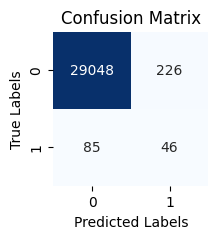

In [92]:

# NORMAL PARAMS & 0.7 THRESHOLD

conf_matrix_xgb = confusion_matrix(y_test,xgb_ta)
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=clf_xgb.classes_, yticklabels=clf_xgb.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [93]:
print('AUC: {:.2f}%'.format(roc_auc_score(y_test, xgb_ta) * 100))
print('F1: {:.2f}%'.format(f1_score(y_test, xgb_ta) * 100))
print('Precision (Class 1): {:.2f}%'.format(precision_score(y_test, xgb_ta) * 100))
print('Recall (Class 0): {:.2f}%'.format(recall_score(y_test, xgb_ta,pos_label=0) * 100))
print('Recall: {:.2f}%'.format(recall_score(y_test, xgb_ta) * 100))
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, xgb_ta) * 100))

AUC: 67.17%
F1: 22.83%
Precision (Class 1): 16.91%
Recall (Class 0): 99.23%
Recall: 35.11%
Accuracy: 98.94%
